In [2]:
import numpy as np
import pandas as pd
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from pandas.tseries.offsets import DateOffset 
from sklearn.preprocessing import MinMaxScaler
from lineartree import LinearTreeRegressor
from joblib import dump, load
import requests
import xmltodict
import joblib
# warnings.filterwarnings('ignore')

# Loading functions

In [11]:
def bdf_request(dataset, id_list):
    token = "your-token"
    url = f"https://api.webstat.banque-france.fr/webstat-fr/v1/data/{dataset}/"
    
    for id in id_list:
        url = url + id + "+"

    headers = {
    "X-IBM-Client-Id": token,
    "accept": "application/json"
    }

    params = {
    # "startPeriod": "2020-Q1",
    # "endPeriod": "2020-Q2"
    }

    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    return data

def parse_bdf_request(data):
    df = pd.DataFrame(columns=['Date'])
    for serie in data['seriesObs']:
        sub_df = pd.DataFrame()
        dates = []
        values = []
        for obs in serie['ObservationsSerie']['observations']:
            dates.append(obs['ObservationPeriod']['periodFirstDate'])
            values.append(pd.to_numeric(obs['ObservationPeriod']['value']))
        sub_df['Date'] = dates
        sub_df[serie['ObservationsSerie']['title']] = values
        df = df.merge(sub_df, on='Date', how='outer')

    if serie['ObservationsSerie']['frequency'] == 'A':
        df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y %H:%M:%S") + pd.offsets.MonthEnd(12)
    elif serie['ObservationsSerie']['frequency'] == 'Q':
        df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y %H:%M:%S") + pd.offsets.MonthEnd(3)  
    elif serie['ObservationsSerie']['frequency'] == 'M':
        df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y %H:%M:%S") + pd.offsets.MonthEnd(1) 
    
    return df

In [15]:
quarterly_bdf_ids_1 = [
    'CFT.Q.N.FR.W0.S1M.S1.N.A.LE.F62A._Z._Z.XDC._T.S.V.N._T',
    'CFT.Q.N.FR.W0.S1M.S1.N.A.LE.F62B._Z._Z.XDC._T.S.V.N._T'
]

quarterly_bdf_ids_2 = [
    'CNF.Q.N.FR.W0.S1M.S1.N.A.LE.F2.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.L.F.F8.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.A.F.F8.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.L.F.F4.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.A.F.F4.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.A.F.F3.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.A.F.F5._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.L.F.F5._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.L.F.F3.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.A.F.F3.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.L.F.F5._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.A.F.F51._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.A.LE.F8.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.L.LE.F8.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.A.F.F6._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.L.F.F6._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.A.LE.F521._Z._Z.XDC._T.S.V.N._T'
]

monthly_bdf_ids_1 = [
    'BSI1.M.FR.N.A.L21.A.1.U6.2250.Z01.E',
    'BSI1.M.FR.N.A.L22.A.1.U6.2250.Z01.E',
    'BSI1.M.FR.N.A.L22FRPL.A.1.U6.2251.Z01.E',
    'BSI1.M.FR.N.A.L23.A.1.U6.2250.Z01.E',
    'BSI1.M.FR.N.A.L23FRLA.A.1.U6.2250.Z01.E',
    'BSI1.M.FR.N.A.L23FRLD.A.1.U6.2251.Z01.E',
    'BSI1.M.FR.N.R.A220Z.A.1.U6.2250.Z01.E',
    'BSI1.M.FR.N.R.A210Z.A.1.U6.2250.Z01.E',
    'BSI1.M.FR.N.R.A2N1Z.A.1.U6.2240.Z01.E',
    'BSI1.M.FR.N.R.A2N2Z.A.1.U6.2240.Z01.E',
    'BSI1.M.FR.N.F.L30.A.8.Z5.0000.Z01.T',
    'BSI1.M.FR.N.A.L22.A.1.U6.2240.Z01.E',
    'BSI1.M.FR.N.A.L21.A.1.U6.2240.Z01.E',
    'BSI1.M.FR.Y.R.A220Z.A.4.U6.2254FR.Z01.E',
    'BSI1.M.FR.N.R.A220Z.A.4.U6.2254FR.Z01.E'
]

monthly_bdf_ids_2 = [
    'MIR1.M.FR.B.A22.A.5.A.2254U6.EUR.N',
    'MIR1.M.FR.B.A2B.A.5.A.2250U6.EUR.N',
    'MIR1.M.FR.B.A22HR.A.5.A.2254U6.EUR.N'
    
]

monthly_bdf_ids_3 = [
    'MIR.M.FR.B.L22.H.R.A.2240.EUR.N'
]

data_bdf_quarterly_1 = bdf_request('CFT', quarterly_bdf_ids_1)
df_bdf_quarterly_1 = parse_bdf_request(data_bdf_quarterly_1)

data_bdf_quarterly_2 = bdf_request('CNF', quarterly_bdf_ids_2)
df_bdf_quarterly_2 = parse_bdf_request(data_bdf_quarterly_2)

df_bdf_quarterly = df_bdf_quarterly_1.merge(df_bdf_quarterly_2, on='Date', how='outer')
df_bdf_quarterly = df_bdf_quarterly.sort_values('Date', ascending=False)
for col in df_bdf_quarterly.columns:
    if col != 'Date':
        df_bdf_quarterly[col] = df_bdf_quarterly[col] * 1e3
display(df_bdf_quarterly.head())

data_bdf_monthly_1 = bdf_request('BSI1', monthly_bdf_ids_1)
df_bdf_monthly_1 = parse_bdf_request(data_bdf_monthly_1)

data_bdf_monthly_2 = bdf_request('MIR1', monthly_bdf_ids_2)
df_bdf_monthly_2 = parse_bdf_request(data_bdf_monthly_2)
for col in df_bdf_monthly_2.columns:
    if col != 'Date':
        df_bdf_monthly_2[col] = df_bdf_monthly_2[col] * 1e3

data_bdf_monthly_3 = bdf_request('MIR', monthly_bdf_ids_3)
df_bdf_monthly_3 = parse_bdf_request(data_bdf_monthly_3)

df_bdf_monthly = df_bdf_monthly_1.merge(df_bdf_monthly_2, on='Date', how='outer').merge(df_bdf_monthly_3, on='Date', how='outer')
df_bdf_monthly = df_bdf_monthly.sort_values('Date', ascending=False)
df_bdf_monthly[["Titres d'OPC monétaires, taux de valorisation de l'encours", "Taux d'intérêt sur contrats nouveaux, DAT, SNF, durée supérieure à 2 ans"]] = df_bdf_monthly[["Titres d'OPC monétaires, taux de valorisation de l'encours", "Taux d'intérêt sur contrats nouveaux, DAT, SNF, durée supérieure à 2 ans"]] / 100
display(df_bdf_monthly.head())


Date  \
110 2023-06-30   
109 2023-03-31   
108 2022-12-31   
107 2022-09-30   
106 2022-06-30   

     Assurance-vie en unités de compte, actif des ménages, encours trimestriel  \
110                                           475101.0                           
109                                           459500.0                           
108                                           435000.0                           
107                                           440700.0                           
106                                           447699.0                           

     Assurance-vie support euro, actif des ménages, encours trimestriel  \
110                                          1466422.0                    
109                                          1472903.0                    
108                                          1448551.0                    
107                                          1435705.0                    
106                                          1492032.0                    

     Actif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - encours de monnaie et dépôts  \
110                                       2.065540e+09                                                                    
109                                       2.046459e+09                                                                    
108                                       2.027083e+09                                                                    
107                                       2.026681e+09                                                                    
106                                       1.995747e+09                                                                    

     Passif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux des autres comptes à recevoir ou à payer  \
110                                        -13809000.0                                                                                      
109                                         18398000.0                                                                                      
108                                        -32099000.0                                                                                      
107                                         -9316000.0                                                                                      
106                                         20464000.0                                                                                      

     Actif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux des autres comptes à recevoir ou à payer  \
110                                        -19898000.0                                                                                     
109                                         18506000.0                                                                                     
108                                        -10055000.0                                                                                     
107                                        -18082000.0                                                                                     
106                                          6569000.0                                                                                     

     Passif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux de crédits  \
110                                          9670000.0                                                        
109                                          7867000.0                                                        
108                                         15415000.0                                                        
107                                         22402000.0                                

Date  Dépôts à vue des ménages et ISBLSM résidents, encours  \
367 2023-10-31                                           583522.0       
366 2023-09-30                                           603888.0       
365 2023-08-31                                           602165.0       
364 2023-07-31                                           610639.0       
363 2023-06-30                                           609965.0       

     Dépôts à terme des ménages et ISBLSM résidents, encours  \
367                                           413585.0         
366                                           409220.0         
365                                           407089.0         
364                                           403900.0         
363                                           397420.0         

     PEL des ménages résidents, encours  \
367                            254318.0   
366                            257948.0   
365                            260856.0   
364                            262634.0   
363                            264820.0   

     Livrets d'épargne des ménages et ISBLSM résidents, encours  \
367                                           875378.0            
366                                           879233.0            
365                                           881965.0            
364                                           878081.0            
363                                           874424.0            

     Livrets A des ménages et ISBLSM résidents, encours  \
367                                           360277.0    
366                                           361582.0    
365                                           360591.0    
364                                           358158.0    
363                                           355054.0    

     Livrets de développement durable et solidaire des ménages résidents, encours  \
367                                           143869.0                              
366                                           144541.0                              
365                                           144272.0                              
364                                           143535.0                              
363                                           142557.0                              

     Crédits à l'habitat accordés aux ménages et ISBLSM résidents, encours  \
367                                          1432574.0                       
366                                          1432126.0                       
365                                          1431864.0                       
364                                          1432978.0                       
363                                          1430095.0                       

     Crédits à la consommation accordés aux ménages et ISBLSM résidents, encours  \
367                                           221498.0                             
366                                           219950.0                             
365                                           219255.0                             
364                                           220007.0                             
363                                           219815.0                             

     Crédits à l'investissement accordés aux sociétés non financières résidentes, encours  \
367                                           951706.0                                      
366                                           948324.0                                      
365                                           949178.0                                      
364                                           948089.0                                      
363                                           942294.0                                      

     Crédits de trésorerie accordés aux sociétés non financières résidentes, encours  \
367                                  

In [ ]:
def insee_request(id_list):
    token = "your-token"
    url = "https://bdm.insee.fr/series/sdmx/data/SERIES_BDM/"
    
    for id in id_list:
        url = url + id + "+"

    headers = {
    "Authorization": f"Bearer {token}"
    }

    params = {
    # "startPeriod": "2020-Q1",
    # "endPeriod": "2020-Q2"
    }

    response = requests.get(url, headers=headers, params=params)
    data = xmltodict.parse(response.content)
    return data

    

def parse_insee_request(data):
    df = pd.DataFrame(columns=['Date'])

    if type(data['message:StructureSpecificData']['message:DataSet']['Series']) == list:
        series = data['message:StructureSpecificData']['message:DataSet']['Series']
    else:
        series = [data['message:StructureSpecificData']['message:DataSet']['Series']]

    for serie in series:
        sub_df = pd.DataFrame()
        unit_mult = 10**float(serie['@UNIT_MULT'])
        dates = []
        values = []
        for obs in serie['Obs']:
            dates.append(obs['@TIME_PERIOD'])
            values.append(float(obs['@OBS_VALUE']) * unit_mult)
        sub_df['Date'] = dates
        
        sub_df[serie['@TITLE_FR']] = values
        df = df.merge(sub_df, on='Date', how='outer')

    if serie['@FREQ'] == 'A':
        df['Date'] = pd.to_datetime(df['Date']) + pd.offsets.MonthEnd(12)
    elif serie['@FREQ'] == 'T':
        df['Date'] = pd.to_datetime(df['Date']) + pd.offsets.MonthEnd(3)  
    elif serie['@FREQ'] == 'M':
        df['Date'] = pd.to_datetime(df['Date']) + pd.offsets.MonthEnd(1)  
    
    return df
    

In [ ]:
annual_insee_ids = [
    '010564058',
    '010563884'
    # '010563893',
]

quarterly_insee_ids = [
    '010564925', #RDB courant
    '010565711', #Conso ménages courant
    '010565712', #Conso ménages constant
    '010564934', #Epargne ménages courant,
    '010565738', #FBCF courant ménages
    '010565734', #FBCF constant ménages
    '010565724', #Exportation courant
    '010565725', #Exportation constant
    '010565726', #Import courant
    '010565727', #Import constant
    '010565717', #Conso totale courant
    '010565718', #Conso totale constant
    '010564879', #Menages aide à l'investissement,
    '010564890',
    '010564889',
    '010564874',
    '010564983',
    '010564909',
    '010564694',
    '010564707',
    '010564734',
    '010564744',
    '010564755',
    '010564767',
    '010564766',
    '010564789',
    '010564848',
    '010564866',
    '010564865',
    '010564833',
    '010564840',
    '010564880',
    '010564892',
    '010564891',
    '010564975',
    '010564898',
    '010565707',
    '010565708',
    '010565730',
    '010565731',
    '010564901',
    '010564931',
    '010564875',
    '010564883',
    '010564884',
    '010564871',
    '010565536',
    '010565746',
    '010565745'
]

monthly_insee_ids = [
   '001769682' #CPI
]

data_insee_annual = insee_request(annual_insee_ids)
df_insee_annual = parse_insee_request(data_insee_annual)
display(df_insee_annual.head())

data_insee_quarterly = insee_request(quarterly_insee_ids)
df_insee_quarterly = parse_insee_request(data_insee_quarterly)
display(df_insee_quarterly.head())

data_insee_monthly = insee_request(monthly_insee_ids)
df_insee_monthly = parse_insee_request(data_insee_monthly)
display(df_insee_monthly.head())

Date  \
0 2021-12-31   
1 2020-12-31   
2 2019-12-31   
3 2018-12-31   
4 2017-12-31   

   Comptes nationaux annuels base 2014 - Acquisitions moins cessions d'actifs non financiers non produits - Sociétés non financières - Emplois ou actifs  \
0                                                NaN                                                                                                       
1                                        522000000.0                                                                                                       
2                                        524000000.0                                                                                                       
3                                         97000000.0                                                                                                       
4                                        465000000.0                                                                                                       

   Comptes nationaux annuels base 2014 - Variation de stocks - Ménages y compris EI - Emplois ou Actifs  
0                                       1.534000e+09                                                     
1                                       1.534000e+09                                                     
2                                       8.610000e+08                                                     
3                                       1.833000e+09                                                     
4                                       8.480000e+08

Date  \
0 2023-09-30   
1 2023-06-30   
2 2023-03-31   
3 2022-12-31   
4 2022-09-30   

   Dépenses de consommation totales - Valeur aux prix courants - Série CVS-CJO  \
0                                       5.432320e+11                             
1                                       5.355780e+11                             
2                                       5.304010e+11                             
3                                       5.226740e+11                             
4                                       5.163810e+11                             

   Exportations - Total - Valeur aux prix courants - Série CVS-CJO  \
0                                       2.282100e+11                 
1                                       2.309040e+11                 
2                                       2.301220e+11                 
3                                       2.348670e+11                 
4                                       2.375390e+11                 

   Prestations d'assistance sociale en espèces versées par les ISBLSM - Valeur aux prix courants - Série CVS  \
0                                        124000000.0                                                           
1                                        123000000.0                                                           
2                                        122000000.0                                                           
3                                        121000000.0                                                           
4                                        121000000.0                                                           

   Investissement des entreprises non financières - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO  \
0                                       8.606800e+10                                                                        
1                                       8.567600e+10                                                                        
2                                       8.468900e+10                                                                        
3                                       8.493900e+10                                                                        
4                                       8.449700e+10                                                                        

   Variations de stocks des sociétés non financières - Valeur aux prix courants - Série CVS-CJO  \
0                                       2.521000e+09                                              
1                                       5.949000e+09                                              
2                                       1.347000e+09                                              
3                                       5.045000e+09                                              
4                                       1.021800e+10                                              

   Acquisitions nettes d'actifs non produits versées par les ménages (y compris les entreprises individuelles) - Valeur aux prix courants - Série CVS  \
0                                       -940000000.0                                                                                                    
1                                       -937000000.0                                                                                                    
2                                       -932000000.0                                                                                                    
3                                       -924000000.0                                                                                                    
4                                       -926000000.0                                                                                                    

   Épargne des sociétés non financières - Valeur aux prix c

Date  \
0 2023-10-31   
1 2023-09-30   
2 2023-08-31   
3 2023-07-31   
4 2023-06-30   

   Indice CVS des prix à la consommation - Base 2015 - Ensemble des ménages - France - Ensemble  
0                                             118.45                                             
1                                             118.52                                             
2                                             118.20                                             
3                                             117.30                                             
4                                             117.30

# I. SNF

In [16]:
train_range = ('2003-03-01', '2022-08-01')

## 1. Arbitrage

In [17]:
df_scenario = pd.read_excel('Envoi_Data_Scenario_France_Central_APR_20230918.xlsx')
df_scenario['Date'] = pd.to_datetime(df_scenario['Date'])
df_scenario.head()

Unnamed: 0       Date  OAT_10Y  EUSW10V3    GDP_courant   GDP_constant  \
0           0 2000-01-31    5.667    5.9090  120586.469136  149927.037037   
1           1 2000-02-29    5.626    5.9210  120783.617284  150098.259259   
2           2 2000-03-31    5.452    5.7735  121157.604938  150428.345679   
3           3 2000-04-30    5.356    5.7127  122064.148148  151213.679012   
4           4 2000-05-31    5.501    5.9057  122665.259259  151695.975309   

   Euribor_3M   CPI  Inflation    CAC40  ...  \
0     3.34314  77.4       1.54  5661.53  ...   
1     3.53675  77.5       1.36  6121.95  ...   
2     3.74704  77.9       1.49  6374.75  ...   
3     3.92904  77.9       1.21  6228.65  ...   
4     4.35038  78.1       1.40  6346.45  ...   

   Households disposable income / constant prices (deflated by household consumption deflator), % ch yoy / quarterly  \
0                                           0.000000                                                                   
1                                           0.000000                                                                   
2                                           2.961124                                                                   
3                                           0.000000                                                                   
4                                           0.000000                                                                   

   Household consumption / constant prices, % ch yoy / quarterly  \
0                                           0.000000               
1                                           0.000000               
2                                           4.776229               
3                                           0.000000               
4                                           0.000000               

   Public consumption / constant prices, % ch yoy / quarterly  \
0                                           0.000000            
1                                           0.000000            
2                                           2.050529            
3                                           0.000000            
4                                           0.000000            

   Investment, private, households / constant prices, % ch yoy / quarterly  \
0                                           0.000000                         
1                                           0.000000                         
2                                           5.579869                         
3                                           0.000000                         
4                                           0.000000                         

   Imports of goods and services / constant prices, % ch yoy / quarterly  \
0                                            0.00000                       
1                                            0.00000                       
2                                           13.37296                       
3                                            0.00000                       
4                                            0.00000                       

   Exports of goods and services / constant prices, % ch yoy / quarterly  \
0                                           0.000000                       
1                                           0.000000                       
2                                          12.360544                       
3                                           0.000000                       
4                                           0.000000                       

   CPI index / % ch yoy / quarterly  \
0                          0.000000   
1                          0.000000   
2                          1.570133   
3                          0.000000   
4                          0.000000   

   Investment, private, NFC / constant prices, % ch yoy / quarterly  \
0                                        

In [18]:
""" Unique processing """
df_scenario['RDB_constant'] = df_scenario['RDB_constant (monthly transformed)']
df_scenario['RDB_courant'] = df_scenario['RDB_courant (monthly transformed)']
df_scenario["GDP / current prices, % ch yoy / quarterly"] = df_scenario["GDP / current prices, % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["GDP / constant prices, % ch yoy / quarterly"] = df_scenario["GDP / constant prices, % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Households disposable income / constant prices (deflated by household consumption deflator), % ch yoy / quarterly"] = df_scenario["Households disposable income / constant prices (deflated by household consumption deflator), % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Household consumption / constant prices, % ch yoy / quarterly"] = df_scenario["Household consumption / constant prices, % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Public consumption / constant prices, % ch yoy / quarterly"] = df_scenario["Public consumption / constant prices, % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Investment, private, households / constant prices, % ch yoy / quarterly"] = df_scenario["Investment, private, households / constant prices, % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Imports of goods and services / constant prices, % ch yoy / quarterly"] = df_scenario["Imports of goods and services / constant prices, % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Exports of goods and services / constant prices, % ch yoy / quarterly"] = df_scenario["Exports of goods and services / constant prices, % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["CPI index / % ch yoy / quarterly"] = df_scenario["CPI index / % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Investment, private, NFC / constant prices, % ch yoy / quarterly"] = df_scenario["Investment, private, NFC / constant prices, % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Non financial companies' saving ratio / constant prices, % of value added / quarterly"] = df_scenario["Non financial companies' saving ratio / constant prices, % of value added / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Non financial companies' profit ratio / constant prices, % of value added / quarterly"] = df_scenario["Non financial companies' profit ratio / constant prices, % of value added / quarterly"].replace(0, np.nan).bfill() / 100

pd.options.display.max_columns = None
df_scenario.head()

Unnamed: 0       Date  OAT_10Y  EUSW10V3    GDP_courant   GDP_constant  \
0           0 2000-01-31    5.667    5.9090  120586.469136  149927.037037   
1           1 2000-02-29    5.626    5.9210  120783.617284  150098.259259   
2           2 2000-03-31    5.452    5.7735  121157.604938  150428.345679   
3           3 2000-04-30    5.356    5.7127  122064.148148  151213.679012   
4           4 2000-05-31    5.501    5.9057  122665.259259  151695.975309   

   Euribor_3M   CPI  Inflation    CAC40  LA_rate  RDB_constant  \
0     3.34314  77.4       1.54  5661.53     2.25           0.0   
1     3.53675  77.5       1.36  6121.95     2.25           0.0   
2     3.74704  77.9       1.49  6374.75     2.25           0.0   
3     3.92904  77.9       1.21  6228.65     2.25           0.0   
4     4.35038  78.1       1.40  6346.45     2.25           0.0   

   RDB_constant (monthly transformed)   RDB_courant  \
0                                 0.0  71971.395062   
1                                 0.0  72106.098765   
2                                 0.0  72376.382716   
3                                 0.0  73008.197531   
4                                 0.0  73363.271605   

   RDB_courant (monthly transformed)  taux_chomage  \
0                       71971.395062           0.0   
1                       72106.098765           0.0   
2                       72376.382716           8.7   
3                       73008.197531           0.0   
4                       73363.271605           0.0   

   GDP / current prices, % ch yoy / quarterly  \
0                                    0.052432   
1                                    0.052432   
2                                    0.052432   
3                                    0.060883   
4                                    0.060883   

   GDP / constant prices, % ch yoy / quarterly  \
0                                     0.043571   
1                                     0.043571   
2                                     0.043571   
3                                     0.047734   
4                                     0.047734   

   Households disposable income / constant prices (deflated by household consumption deflator), % ch yoy / quarterly  \
0                                           0.029611                                                                   
1                                           0.029611                                                                   
2                                           0.029611                                                                   
3                                           0.033617                                                                   
4                                           0.033617                                                                   

   Household consumption / constant prices, % ch yoy / quarterly  \
0                                           0.047762               
1                                           0.047762               
2                                           0.047762               
3                                           0.048541               
4                                           0.048541               

   Public consumption / constant prices, % ch yoy / quarterly  \
0                                           0.020505            
1                                           0.020505            
2                                           0.020505            
3                                           0.021410            
4                                           0.021410            

   Investment, private, households / constant prices, % ch yoy / quarterly  \
0                                           0.055799                         
1                                           0.055799                         
2                                           0.055799                         
3                                           0.045539      

In [19]:
df_target = df_bdf_monthly[['Date', 'Dépôts à vue des SNF résidentes, encours', 'Dépôts à terme des SNF résidentes, encours']]
df_target = df_target.merge(df_bdf_quarterly[["Date", "Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours d'OPC monétaires"]], on='Date', how='left')
df_target["Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours d'OPC monétaires"] = df_target["Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours d'OPC monétaires"].bfill() / 1e3

In [20]:
### SNF
model_dav_part_stable_SNF = load(f'dav_part_stable_SNF.joblib')
drivers = ['OAT_10Y_diff', 'EUSW10V3_diff', 'Inflation_diff', 'SNF_flux_credit'] + [f"month_{i}" for i in range(3, 13)]

df_dav_SNF_histo = df_bdf_monthly[['Date', "Crédits à l'investissement accordés aux sociétés non financières résidentes, encours", "Crédits de trésorerie accordés aux sociétés non financières résidentes, encours", "Dépôts à vue des SNF résidentes, encours"]]
df_dav_SNF_histo = df_dav_SNF_histo.merge(df_scenario, on='Date', how='left')
df_dav_SNF_histo['SNF_flux_credit'] = df_dav_SNF_histo[["Crédits à l'investissement accordés aux sociétés non financières résidentes, encours", "Crédits de trésorerie accordés aux sociétés non financières résidentes, encours"]].sum(axis=1).diff()
df_dav_SNF_histo['OAT_10Y_diff'] = df_dav_SNF_histo['OAT_10Y'].diff()
df_dav_SNF_histo['EUSW10V3_diff'] = df_dav_SNF_histo['EUSW10V3'].diff()
df_dav_SNF_histo['Inflation_diff'] = df_dav_SNF_histo['Inflation'].diff()
for i in range(1,13):
    df_dav_SNF_histo[f"month_{i}"] = (df_dav_SNF_histo['Date'].dt.month == i).astype(int)
df_dav_SNF_histo = df_dav_SNF_histo[df_dav_SNF_histo['Date'] >= "2013-12"]
df_dav_SNF_histo = df_dav_SNF_histo.sort_values('Date', ascending=True)

df_dav_SNF_histo['dav_part_stable_SNF_diff'] = model_dav_part_stable_SNF.predict(df_dav_SNF_histo[drivers].fillna(0))
dav_part_stable_init =  df_dav_SNF_histo[(df_dav_SNF_histo['Date'].dt.year==2013) & (df_dav_SNF_histo['Date'].dt.month==12)]['Dépôts à vue des SNF résidentes, encours'].values[0] 
df_dav_SNF_histo['dav_part_stable_SNF_histo'] = dav_part_stable_init + (df_dav_SNF_histo['dav_part_stable_SNF_diff'] * (df_dav_SNF_histo['Date'].dt.year > 2013)).cumsum()

df_target = df_target.merge(df_dav_SNF_histo[['Date', 'dav_part_stable_SNF_histo']], on='Date', how='left')


c:\Users\Admin\miniconda3\envs\lfayolle\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.1.3 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\miniconda3\envs\lfayolle\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [21]:
df_target['SNF_DAV_Vol'] = (df_target['Dépôts à vue des SNF résidentes, encours'] - df_target['dav_part_stable_SNF_histo']).fillna(0.)
df_target['SNF_DAV_Vol'] = df_target['SNF_DAV_Vol'].apply(lambda x: max(x, 0))
df_target['SNF_DAT'] = df_target['Dépôts à terme des SNF résidentes, encours']
df_target['SNF_OPC'] = df_target["Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours d'OPC monétaires"]

df_drivers = df_scenario.copy()

C:\Users\Admin\AppData\Local\Temp\ipykernel_39012\245881639.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['total'] = df_train[target_to_drivers.keys()].sum(axis=1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_39012\245881639.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[k+'_ratio'] = df_train[k]/df_train['total']
C:\Users\Admin\AppData\Local\Temp\ipykernel_39012\245881639.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

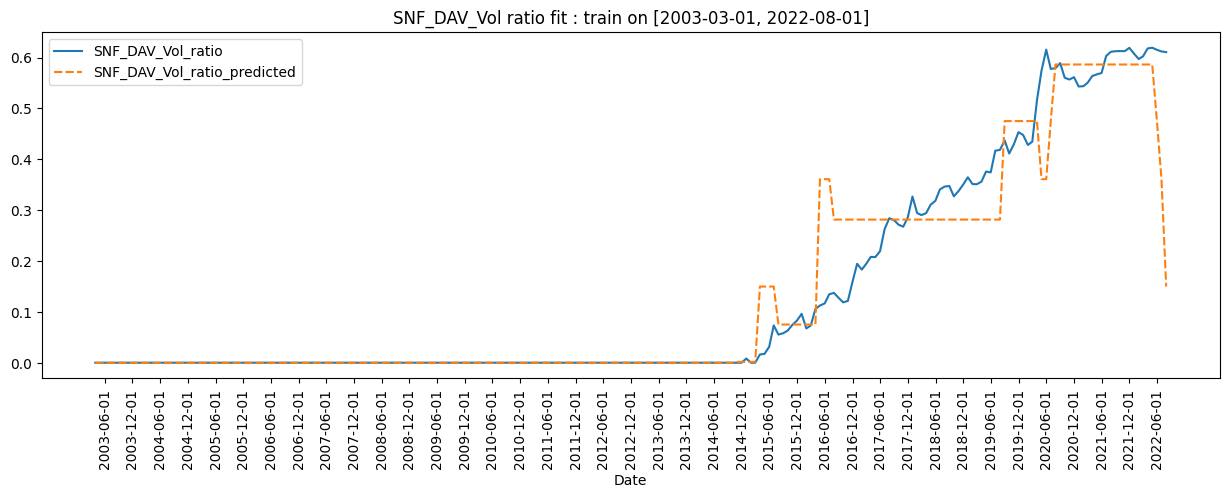

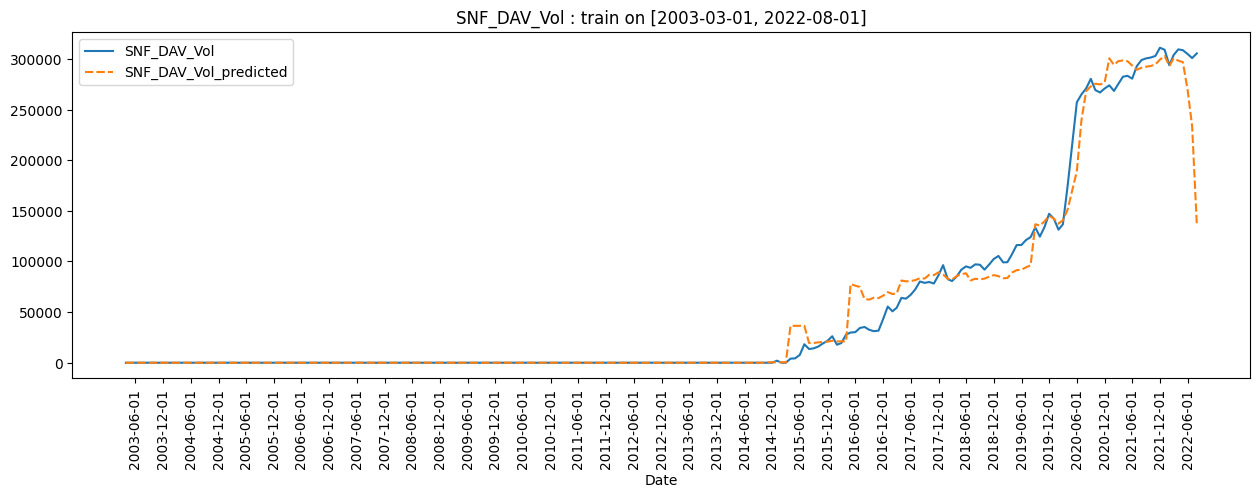

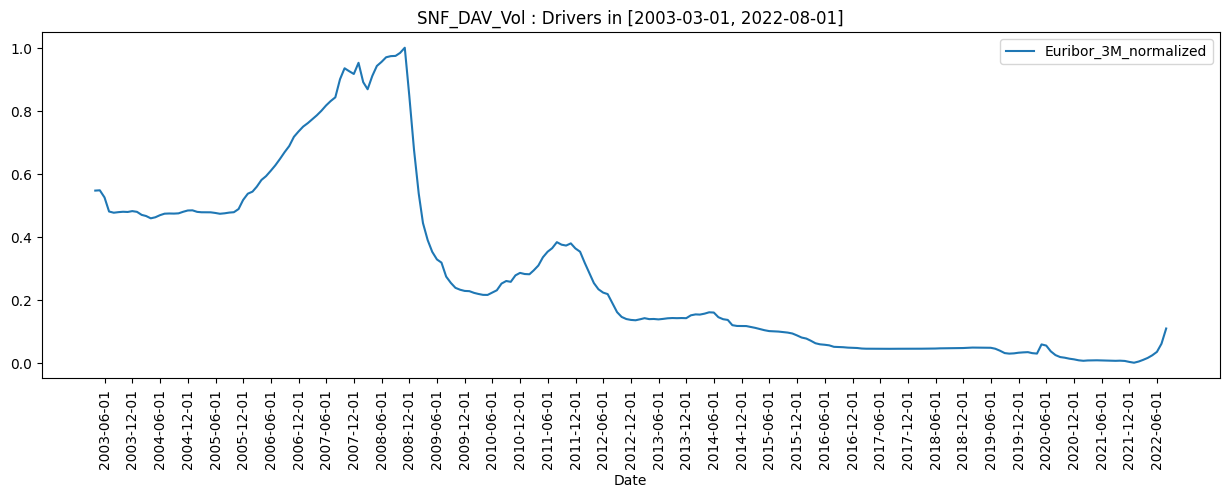

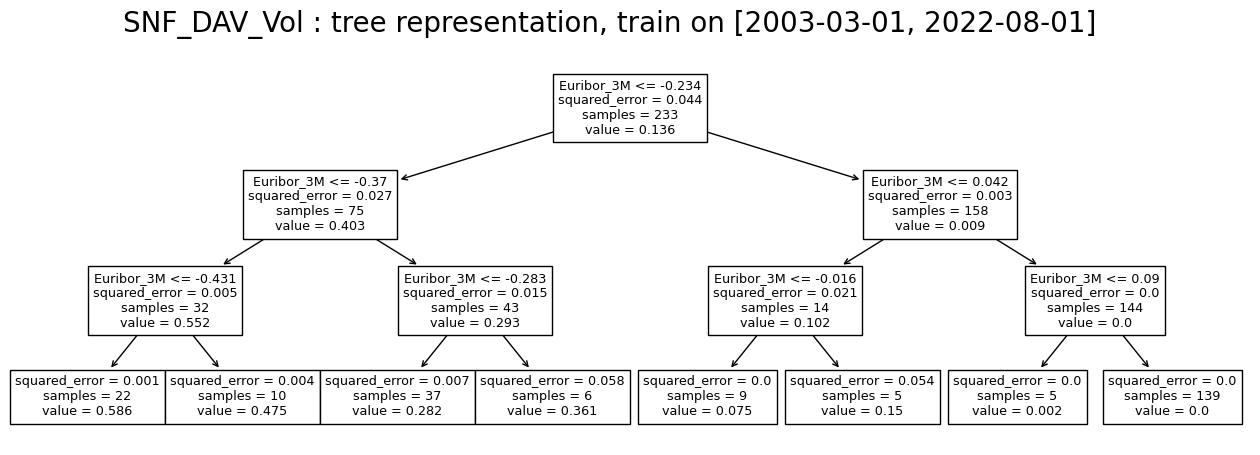

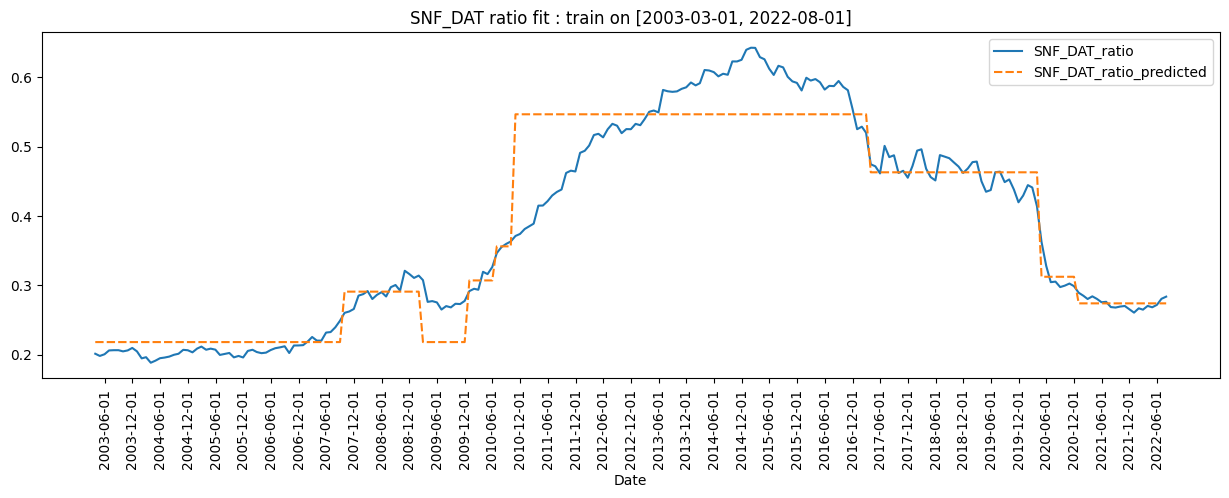

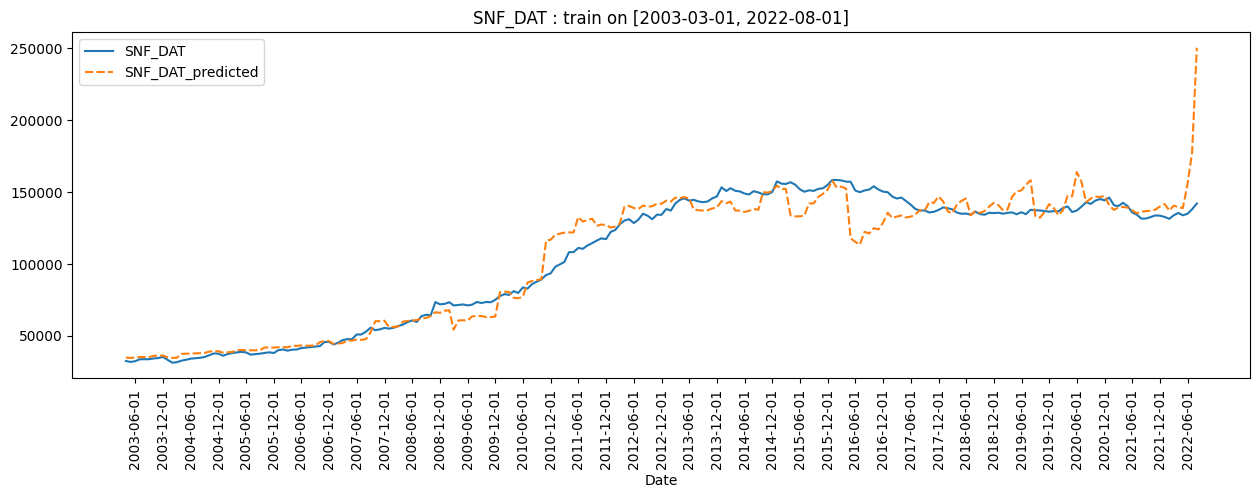

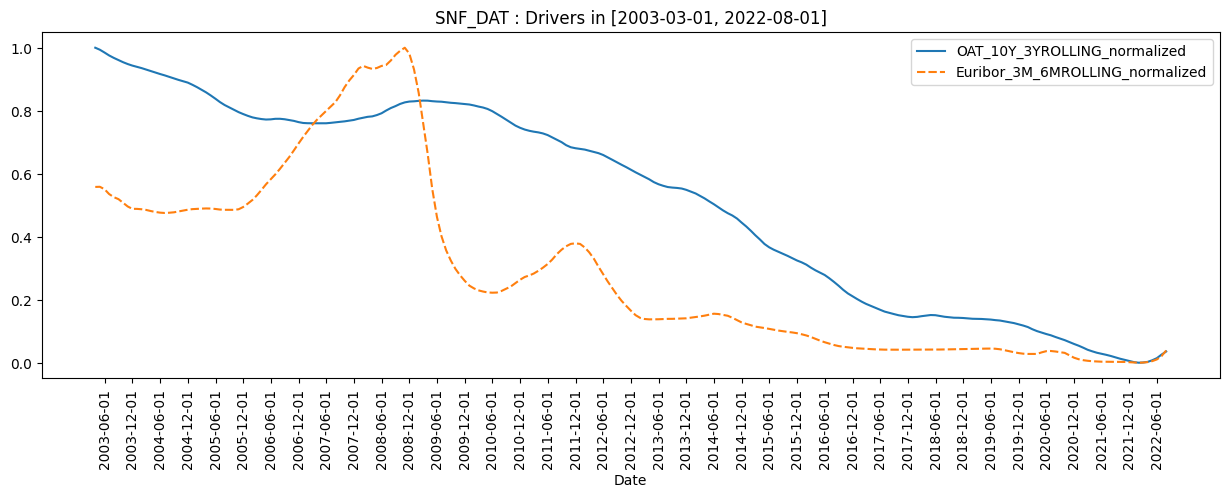

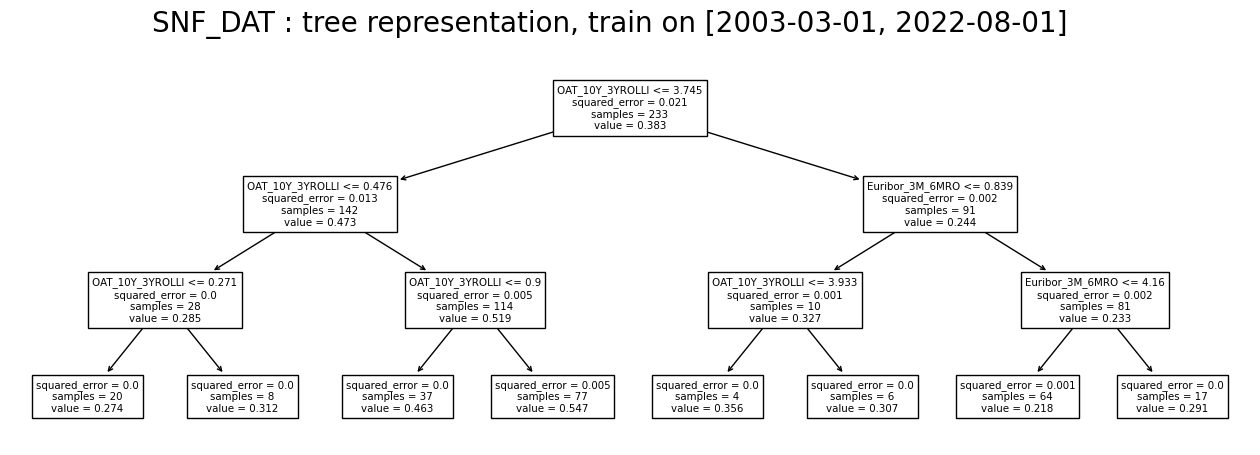

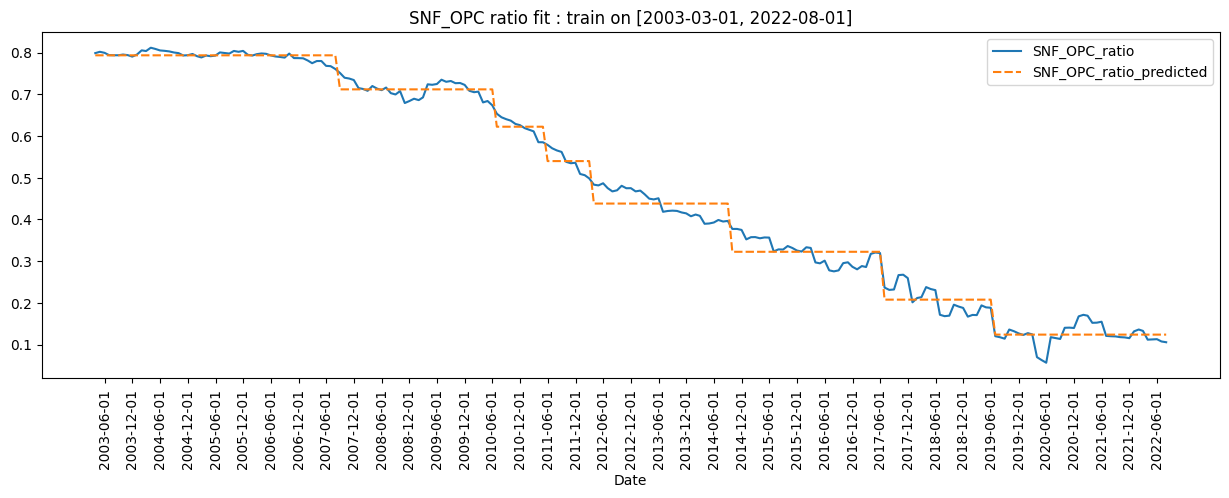

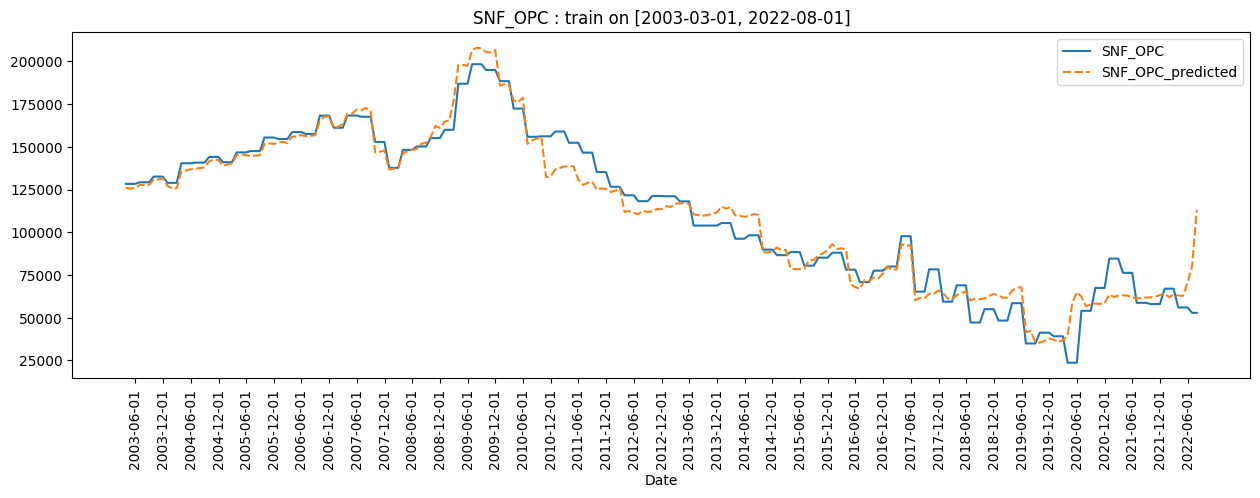

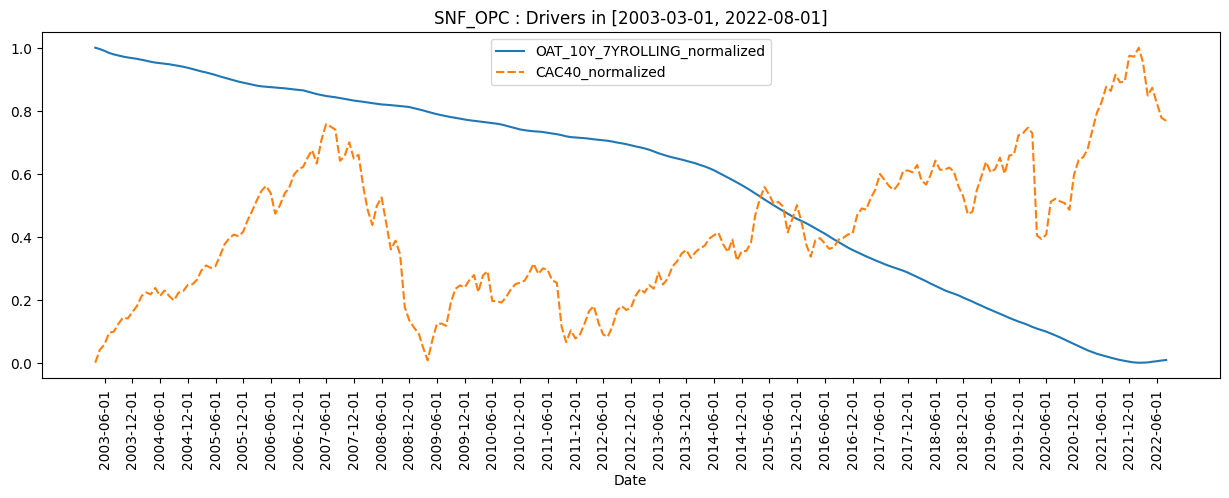

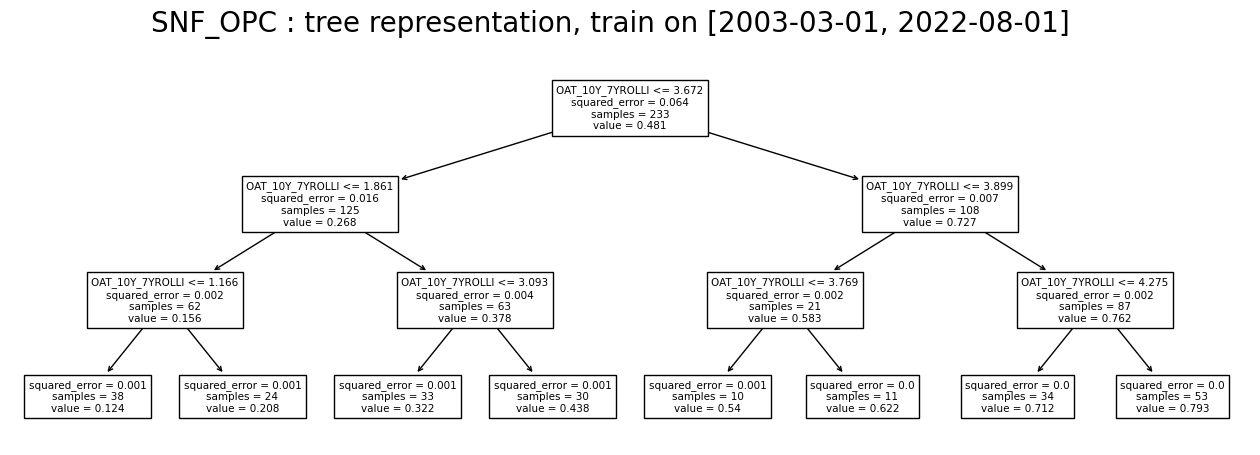

In [22]:
""" Arbitration model fit """

'''LOADING DATA SOURCES'''


# Loading file containing historical drivers used to fit models as well as the drivers used for projection 
df_drivers['Date'] = pd.to_datetime(df_drivers['Date'], format='%YM%m')

# Loading file containing historical targets (here. France deposits) used to fit models

# Building a common dataframe containing drivers and targets
df = df_drivers.merge(df_target, on='Date', how='left').replace('n.a.', np.nan)


'''Feature engineering'''

df['LA_minus_OAT'] = df['LA_rate'] - df['OAT_10Y'].rolling(window=5, min_periods=1).mean()
df['OAT_10Y_3YROLLING'] = df['OAT_10Y'].rolling(window=12*3, min_periods=1).mean()
df['OAT_10Y_7YROLLING'] = df['OAT_10Y'].rolling(window=12*7, min_periods=1).mean()
# df['Menages_DAV_Stable'] = df['Menages_DAV'] - df['Menages_DAV_Vol']
# df['Epargne_menages_ratio'] = df['Epargne_menages_courant'] / df['RDB_courant']


'''Selecting training range and prediction range'''

# Picking historical training range in years/date (bounds included)
# train_range = ('2003-03-01', '2022-09-01')
# backtest_range = ('2022-04-01', '2022-09-01')
# prediction_range = ('2022-06-01', '2027-12-01')


'''Selecting drivers used to make predictions as well as model types'''

target_to_drivers = {
    "SNF_DAV_Vol": ["Euribor_3M"],
    "SNF_DAT": ["OAT_10Y_3YROLLING", "Euribor_3M_6MROLLING"],
    "SNF_OPC": ["OAT_10Y_7YROLLING", "CAC40"]
}
reference = 'Euribor_3M'

models = {
    "SNF_DAV_Vol": DecisionTreeRegressor(max_depth=3, min_samples_leaf=5),
    "SNF_DAT": DecisionTreeRegressor(max_depth=3),
    "SNF_OPC": DecisionTreeRegressor(max_depth=3)
}


'''CALIBRAGE ET PREDICTION'''

df_train = df[(df['Date']<=train_range[1]) & (df['Date']>=train_range[0])]

global_shift = 0
df_train['total'] = df_train[target_to_drivers.keys()].sum(axis=1)
for (k,v) in target_to_drivers.items():
    df_train[k+'_ratio'] = df_train[k]/df_train['total']
    max_shift = 0
    for driver in v:
        if '_shifted_' in driver:
            shift_val = int(driver.split('_')[-1])
            df_train[driver] = df_train['_'.join(driver.split('_')[:-2])].shift(shift_val).fillna(0)
            max_shift = max(max_shift, shift_val)
            global_shift = max(global_shift, shift_val)
        elif '_variation' in driver:
            df_train[driver] = ((df_train['_'.join(driver.split('_')[:-1])] - df_train['_'.join(driver.split('_')[:-1])].shift(1)) / df_train['_'.join(driver.split('_')[:-1])].shift(1)).fillna(0.)
        elif '_referenced' in driver:
            df_train[driver] = (df_train['_'.join(driver.split('_')[:-1])] / df_train[reference]).fillna(0.)
        elif "_6MROLLING" in driver:
            df_train[driver] = df_train['_'.join(driver.split('_')[:-1])].rolling(6, min_periods=1).mean()
    df_train_shift = df_train[df_train['Date']>=df_train['Date'].min()+ DateOffset(months=max_shift)]
    # if k=="SNF_DAV_Vol":
    #     df_train_shift = df_train_shift[df_train_shift['Date']>="2013-04-01"]
    models[k] = models[k].fit(df_train_shift[v], df_train_shift[k+'_ratio'])
    model = models[k]
    df_train[k+'_ratio_predicted'] = model.predict(df_train[v])
    df_train[k+'_ratio_predicted_adjusted'] = df_train[k+'_ratio_predicted'].apply(lambda x: max(x,0))

standardization_factor = df_train[[x+'_ratio_predicted_adjusted' for x in target_to_drivers.keys()]].sum(axis=1)
for (k,v) in target_to_drivers.items():
    df_train[k+'_ratio_predicted_adjusted'] = df_train[k+'_ratio_predicted_adjusted'] / standardization_factor
    df_train[k+'_predicted'] = df_train[k+'_ratio_predicted_adjusted']*df_train['total']

df_plot = df_train.copy()
df_plot = df_plot[df_plot['Date']>=df_plot['Date'].min()+ DateOffset(months=global_shift)].set_index('Date')
for k in target_to_drivers.keys():
    fig, ax =plt.subplots(1,1)
    fig.set_figheight(4.5)
    fig.set_figwidth(15.2)
    
    if k=="Menages_DAV_Vol":
        figure = sns.lineplot(data=df_plot[df_plot.index>="2015-04-01"][[k+'_ratio', k+'_ratio_predicted']], ax=ax)
        figure.set_title(f"{k} ratio fit : train on [2015-04-01, {train_range[1]}]")
        ticks = pd.Series(df_plot[df_plot.index>="2015-04-01"].index).dt.strftime('%Y-%m')
        ticks = [x for x in ticks if x[-2:] in ['06', '12']]
        figure.set_xticks(ticks)
        plt.xticks(rotation=90)
        fig.show()

        fig, ax =plt.subplots(1,1)
        fig.set_figheight(4.5)
        fig.set_figwidth(15.2)
        figure = sns.lineplot(data=df_plot[df_plot.index>="2015-04-01"][[k, k+'_predicted']], ax=ax)
        figure.set_title(f"{k} : train on [2015-04-01, {train_range[1]}]")
        ticks = pd.Series(df_plot[df_plot.index>="2015-04-01"].index).dt.strftime('%Y-%m')
        ticks = [x for x in ticks if x[-2:] in ['06', '12']]
        figure.set_xticks(ticks)
        plt.xticks(rotation=90)
        fig.show()

        for driver in target_to_drivers[k]:
            df_plot[driver+'_normalized'] = (df_plot[driver] - df_plot[driver].min()) / (df_plot[driver].max() - df_plot[driver].min())

        fig, ax =plt.subplots(1,1)
        fig.set_figheight(4.5)
        fig.set_figwidth(15.2)
        figure = sns.lineplot(data=df_plot[df_plot.index>="2015-04-01"][[d+'_normalized' for d in target_to_drivers[k]]], ax=ax)
        figure.set_title(f"{k} : Drivers in [2015-04-01, {train_range[1]}]")
        ticks = pd.Series(df_plot[df_plot.index>="2015-04-01"].index).dt.strftime('%Y-%m')
        ticks = [x for x in ticks if x[-2:] in ['06', '12']]
        figure.set_xticks(ticks)
        plt.xticks(rotation=90)
        fig.show()

    else:
        figure = sns.lineplot(data=df_plot[[k+'_ratio', k+'_ratio_predicted']], ax=ax)
        figure.set_title(f"{k} ratio fit : train on [{train_range[0]}, {train_range[1]}]")
        ticks = pd.Series(df_plot.index).dt.strftime('%Y-%m')
        ticks = [x for x in ticks if x[-2:] in ['06', '12']]
        figure.set_xticks(ticks)
        plt.xticks(rotation=90)
        fig.show()

        fig, ax =plt.subplots(1,1)
        fig.set_figheight(4.5)
        fig.set_figwidth(15.2)
        figure = sns.lineplot(data=df_plot[[k, k+'_predicted']], ax=ax)
        figure.set_title(f"{k} : train on [{train_range[0]}, {train_range[1]}]")
        ticks = pd.Series(df_plot.index).dt.strftime('%Y-%m')
        ticks = [x for x in ticks if x[-2:] in ['06', '12']]
        figure.set_xticks(ticks)
        plt.xticks(rotation=90)
        fig.show()

        for driver in target_to_drivers[k]:
            df_plot[driver+'_normalized'] = (df_plot[driver] - df_plot[driver].min()) / (df_plot[driver].max() - df_plot[driver].min())
        fig, ax =plt.subplots(1,1)
        fig.set_figheight(4.5)
        fig.set_figwidth(15.2)
        figure = sns.lineplot(data=df_plot[[d+'_normalized' for d in target_to_drivers[k]]], ax=ax)
        figure.set_title(f"{k} : Drivers in [{train_range[0]}, {train_range[1]}]")
        ticks = pd.Series(df_plot.index).dt.strftime('%Y-%m')
        ticks = [x for x in ticks if x[-2:] in ['06', '12']]
        figure.set_xticks(ticks)
        plt.xticks(rotation=90)
        fig.show()

    fig, ax =plt.subplots(1,1)
    fig.set_figheight(5)
    fig.set_figwidth(16)

    if k=="Menages_DAV_Vol":
        tree.plot_tree(models[k], feature_names=[d[:12] for d in target_to_drivers[k]], ax=ax)
        fig.suptitle(f"{k} : tree representation, train on [2015-04-01, {train_range[1]}]", fontsize=20)
    else:  
        tree.plot_tree(models[k], feature_names=[d[:15] for d in target_to_drivers[k]], ax=ax)
        fig.suptitle(f"{k} : tree representation, train on [{train_range[0]}, {train_range[1]}]", fontsize=20)
    fig.show()



# for k, v in models.items():
#     joblib.dump(v, f"models/arbitrage_SNF/{k}.joblib")


## 2. Crédit investissement

In [23]:
# Data loading

df_y = df_bdf_monthly[["Date", "Crédits à l'investissement accordés aux sociétés non financières résidentes, encours"]]
df_x = pd.read_excel("Data_Scenario.xlsx")
df_x = df_x.merge(df_insee_quarterly, on='Date', how='left')
for col in df_insee_quarterly.columns:
    if col != 'Date':
        df_x[col] = df_x[col].bfill() / (1e6 * 3)

df = df_y.merge(df_x, on="Date", how="left")
df = df.sort_values('Date', ascending=True)

In [24]:
# Feature engineering

df.rename(columns={"Crédits à l'investissement accordés aux sociétés non financières résidentes, encours": "Crédit_invest"}, inplace=True)

df['OAT_10Y_minus_inflation'] = df['OAT_10Y'] - df['Inflation']
df['Crédit_invest_diff'] = df['Crédit_invest'].diff()

for i in range(1, 7):
    df[f'Crédit_invest_shift_{i}'] = df['Crédit_invest'].shift(i)


In [25]:
train_range = ("2001-01-01", "2018-06-01")
backtest_range = ("2018-07-01", "2019-12-01")

df_train = df[(df['Date']>=train_range[0]) & (df['Date']<=train_range[1])]
display(df_train.head())

df_backtest = df[(df['Date']>=backtest_range[0]) & (df['Date']<=backtest_range[1])]

Date  Crédit_invest  Unnamed: 0  OAT_10Y  EUSW10V3    GDP_courant  \
273 2001-01-31       279140.0        12.0    4.947    4.7420  126575.419753   
272 2001-02-28       279997.0        13.0    4.939    4.7492  126939.716049   
271 2001-03-31       279911.0        14.0    4.837    4.5970  127276.864198   
270 2001-04-30       280175.0        15.0    5.014    4.6607  127550.222222   
269 2001-05-31       283174.0        16.0    5.212    4.7563  127860.555556   

      GDP_constant  Euribor_3M   CPI  Inflation    CAC40  LA_rate  \
273  154582.851852     4.77438  78.5       1.21  5827.89      3.0   
272  154773.629630     4.75579  78.7       1.36  5634.29      3.0   
271  154902.518519     4.70863  79.1       1.34  5200.62      3.0   
270  154854.456790     4.68770  79.5       1.83  5346.71      3.0   
269  154945.864198     4.64386  80.0       2.26  5558.87      3.0   

     RDB_constant   RDB_courant  taux_chomage  \
273  94058.988957  76672.358025           0.0   
272  94413.143398  76683.950617           0.0   
271  94716.956575  76783.691358           7.4   
270  94902.509910  76963.629630           0.0   
269  95156.579489  77245.629630           0.0   

     GDP / current prices, % ch yoy / quarterly  \
273                                    0.052383   
272                                    0.052383   
271                                    0.052383   
270                                    0.052383   
269                                    0.052383   

     GDP / constant prices, % ch yoy / quarterly  \
273                                     0.008283   
272                                     0.008283   
271                                     0.008283   
270                                     0.008283   
269                                     0.008283   

     Households disposable income / constant prices (deflated by household consumption deflator), % ch yoy / quarterly  \
273                                          -0.000394                                                                   
272                                          -0.000394                                                                   
271                                          -0.000394                                                                   
270                                          -0.000394                                                                   
269                                          -0.000394                                                                   

     Household consumption / constant prices, % ch yoy / quarterly  \
273                                           0.005826               
272                                           0.005826               
271                                           0.005826               
270                                           0.005826               
269                                           0.005826               

     Public consumption / constant prices, % ch yoy / quarterly  \
273                                           0.011078            
272                                           0.011078            
271                                           0.011078            
270                                           0.011078            
269                                           0.011078            

     Investment, private, households / constant prices, % ch yoy / quarterly  \
273                                          -0.015187                         
272                                          -0.015187                         
271                                          -0.015187                         
270                                          -0.015187                         
269                                          -0.015187                         

     Imports of goods and services / constant prices, % ch yoy / quarterly  \
273                                           0.123162                       
272        

In [26]:
amort_stock = 12 * 4
amort = 12 * 7

drivers = ["Investissement des entreprises non financières - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO", 'OAT_10Y_minus_inflation']

timesteps = df_train.shape[0]
encours_init = df[df["Date"]<train_range[0]]['Crédit_invest'].values[-1]

stock_outstanding = [max(encours_init * (1 - i / amort_stock), 0) for i in range(1, timesteps+1)]
target_outstanding = df_train['Crédit_invest'].values

target_np = target_outstanding - stock_outstanding

np_amort_matrix_init = np.array([max(1 - i / amort, 0) for i in range(timesteps)])
np_amort_matrix = np.array([np_amort_matrix_init])
for i in range(1, timesteps):
    np_amort_matrix = np.concatenate([np_amort_matrix, np.roll(np_amort_matrix_init, i)[None, :]])
np_amort_matrix = np.triu(np_amort_matrix)

new_prod = np.linalg.solve(np_amort_matrix.T, target_np)

lr = LinearRegression().fit(df_train[drivers], new_prod)

from joblib import dump, load
# dump(lr, 'models/_new/credit_investissement.joblib') 

C:\Users\Admin\AppData\Local\Temp\ipykernel_39012\2274517350.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Crédit_invest_predict'] = predict_outstanding
C:\Users\Admin\AppData\Local\Temp\ipykernel_39012\2274517350.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


fit : MAPE of 3.07%


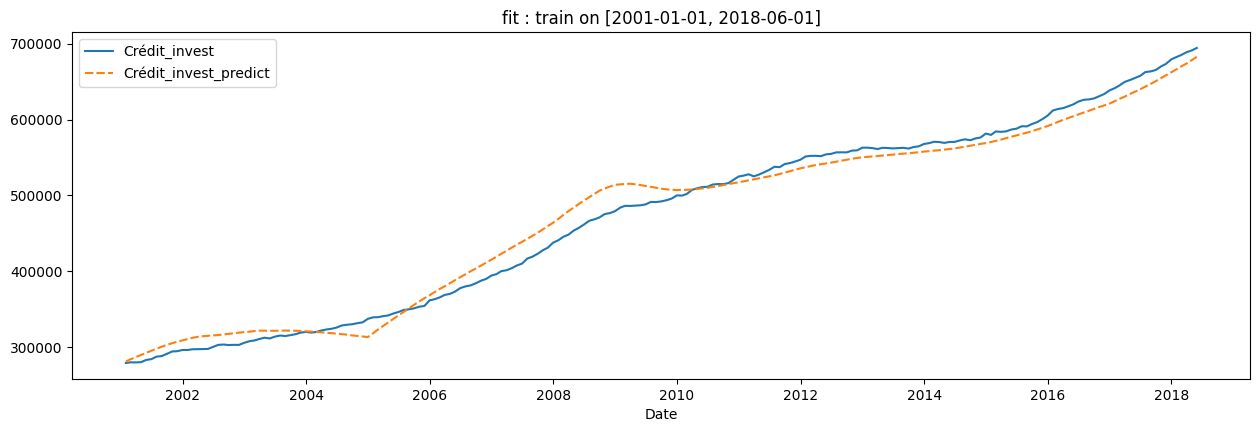

In [27]:
predict_new_prods = lr.predict(df_train[drivers])
predict_new_prods = np.triu(np.ones((timesteps, timesteps))) * predict_new_prods[:, None]
predict_new_prods = predict_new_prods * np_amort_matrix

predict_outstanding = np.sum(predict_new_prods, axis=0) + stock_outstanding

df_train['Crédit_invest_predict'] = predict_outstanding

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_train.set_index("Date")[["Crédit_invest", "Crédit_invest_predict"]], ax=ax)
figure.set_title(f"fit : train on [{train_range[0]}, {train_range[1]}]")
mape = sk.metrics.mean_absolute_percentage_error(df_train['Crédit_invest'], df_train['Crédit_invest_predict'])
print(f"fit : MAPE of {round(100*mape, 2)}%")
fig.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_39012\924289294.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backtest['Crédit_invest_predict'] = total_outstanding[timesteps:]
C:\Users\Admin\AppData\Local\Temp\ipykernel_39012\924289294.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


fit : MAPE of 0.35%


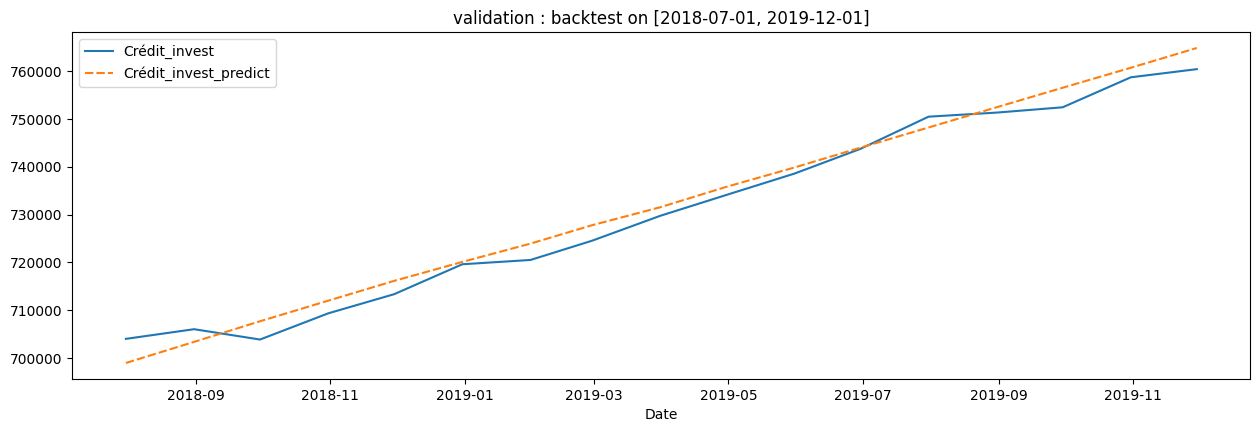

In [28]:
timesteps_total = timesteps + df_backtest.shape[0]

past_new_prods = new_prod
predict_new_prods = lr.predict(df_backtest[drivers])
total_new_prods = np.concatenate([past_new_prods, predict_new_prods])
total_new_prods = np.triu(np.ones((timesteps_total, timesteps_total))) * total_new_prods[:, None]

np_amort_matrix_init = np.array([max(1 - i / amort, 0) for i in range(timesteps_total)])
np_amort_matrix = np.array([np_amort_matrix_init])
for i in range(1, timesteps_total):
    np_amort_matrix = np.concatenate([np_amort_matrix, np.roll(np_amort_matrix_init, i)[None, :]])
np_amort_matrix = np.triu(np_amort_matrix)

total_new_prods = total_new_prods * np_amort_matrix
stock_outstanding = [max(encours_init * (1 - i / amort_stock), 0) for i in range(1, timesteps_total+1)]

total_outstanding = np.sum(total_new_prods, axis=0) + stock_outstanding

df_backtest['Crédit_invest_predict'] = total_outstanding[timesteps:]

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_backtest.set_index("Date")[["Crédit_invest", "Crédit_invest_predict"]], ax=ax)
figure.set_title(f"validation : backtest on [{backtest_range[0]}, {backtest_range[1]}]")
mape = sk.metrics.mean_absolute_percentage_error(df_backtest['Crédit_invest'], df_backtest['Crédit_invest_predict'])
print(f"fit : MAPE of {round(100*mape, 2)}%")
fig.show()

## 2. Crédit trésorerie

In [29]:
# Data loading

df_y = df_bdf_monthly[["Date", "Crédits de trésorerie accordés aux sociétés non financières résidentes, encours"]]
df_x = pd.read_excel("Data_Scenario.xlsx")
df_x = df_x.merge(df_insee_quarterly, on='Date', how='left')
for col in df_insee_quarterly.columns:
    if col != 'Date':
        df_x[col] = df_x[col].bfill() / (1e6 * 3)

df = df_y.merge(df_x, on="Date", how="left")
df = df.sort_values('Date', ascending=True)

In [30]:
# Feature engineering

df.rename(columns={"Crédits de trésorerie accordés aux sociétés non financières résidentes, encours": "Crédit_treso"}, inplace=True)

In [31]:
train_range = ("2001-01-01", "2018-06-01")
backtest_range = ("2018-07-01", "2019-12-01")

df_train = df[(df['Date']>=train_range[0]) & (df['Date']<=train_range[1])]
display(df_train.head())

df_backtest = df[(df['Date']>=backtest_range[0]) & (df['Date']<=backtest_range[1])]

Date  Crédit_treso  Unnamed: 0  OAT_10Y  EUSW10V3    GDP_courant  \
273 2001-01-31      170663.0        12.0    4.947    4.7420  126575.419753   
272 2001-02-28      171724.0        13.0    4.939    4.7492  126939.716049   
271 2001-03-31      174580.0        14.0    4.837    4.5970  127276.864198   
270 2001-04-30      184447.0        15.0    5.014    4.6607  127550.222222   
269 2001-05-31      183041.0        16.0    5.212    4.7563  127860.555556   

      GDP_constant  Euribor_3M   CPI  Inflation    CAC40  LA_rate  \
273  154582.851852     4.77438  78.5       1.21  5827.89      3.0   
272  154773.629630     4.75579  78.7       1.36  5634.29      3.0   
271  154902.518519     4.70863  79.1       1.34  5200.62      3.0   
270  154854.456790     4.68770  79.5       1.83  5346.71      3.0   
269  154945.864198     4.64386  80.0       2.26  5558.87      3.0   

     RDB_constant   RDB_courant  taux_chomage  \
273  94058.988957  76672.358025           0.0   
272  94413.143398  76683.950617           0.0   
271  94716.956575  76783.691358           7.4   
270  94902.509910  76963.629630           0.0   
269  95156.579489  77245.629630           0.0   

     GDP / current prices, % ch yoy / quarterly  \
273                                    0.052383   
272                                    0.052383   
271                                    0.052383   
270                                    0.052383   
269                                    0.052383   

     GDP / constant prices, % ch yoy / quarterly  \
273                                     0.008283   
272                                     0.008283   
271                                     0.008283   
270                                     0.008283   
269                                     0.008283   

     Households disposable income / constant prices (deflated by household consumption deflator), % ch yoy / quarterly  \
273                                          -0.000394                                                                   
272                                          -0.000394                                                                   
271                                          -0.000394                                                                   
270                                          -0.000394                                                                   
269                                          -0.000394                                                                   

     Household consumption / constant prices, % ch yoy / quarterly  \
273                                           0.005826               
272                                           0.005826               
271                                           0.005826               
270                                           0.005826               
269                                           0.005826               

     Public consumption / constant prices, % ch yoy / quarterly  \
273                                           0.011078            
272                                           0.011078            
271                                           0.011078            
270                                           0.011078            
269                                           0.011078            

     Investment, private, households / constant prices, % ch yoy / quarterly  \
273                                          -0.015187                         
272                                          -0.015187                         
271                                          -0.015187                         
270                                          -0.015187                         
269                                          -0.015187                         

     Imports of goods and services / constant prices, % ch yoy / quarterly  \
273                                           0.123162                       
272              

In [32]:
amort_stock = 12 * 4
amort = 12 * 7

drivers = ["Investissement des entreprises non financières - Total - Valeur aux prix courants - Série CVS-CJO", 'OAT_10Y']

lr = LinearRegression().fit(df_train[drivers], df_train["Crédit_treso"])

from joblib import dump, load
# dump(lr, 'models/_new/credit_tresorerie.joblib') 

fit : MAPE of 6.2%


C:\Users\Admin\AppData\Local\Temp\ipykernel_39012\287718170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Crédit_treso_predict'] = lr.predict(df_train[drivers])
C:\Users\Admin\AppData\Local\Temp\ipykernel_39012\287718170.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


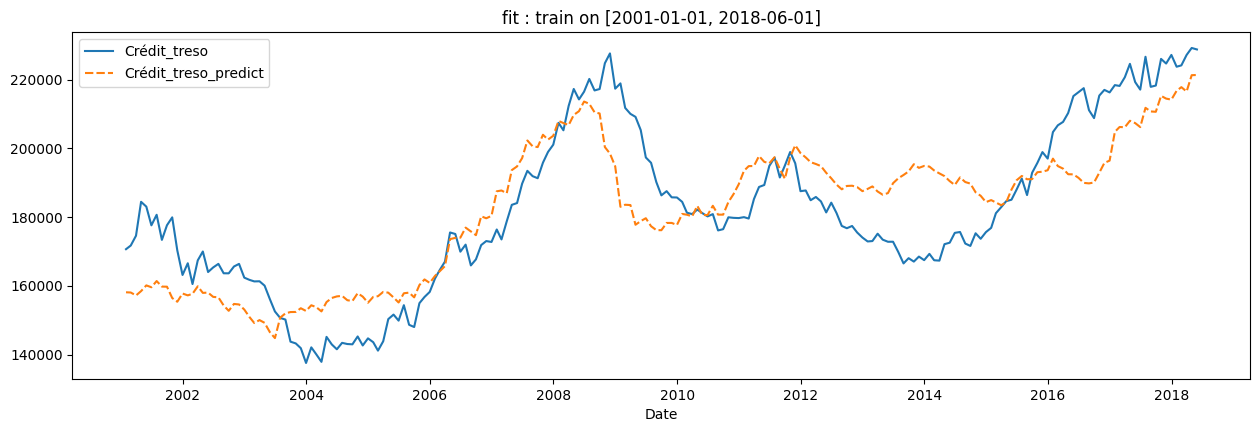

In [34]:
df_train['Crédit_treso_predict'] = lr.predict(df_train[drivers])

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_train.set_index("Date")[["Crédit_treso", "Crédit_treso_predict"]], ax=ax)
figure.set_title(f"fit : train on [{train_range[0]}, {train_range[1]}]")
mape = sk.metrics.mean_absolute_percentage_error(df_train['Crédit_treso'], df_train['Crédit_treso_predict'])
print(f"fit : MAPE of {round(100*mape, 2)}%")
fig.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_39012\4262722628.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backtest['Crédit_treso_predict'] = lr.predict(df_backtest[drivers])
C:\Users\Admin\AppData\Local\Temp\ipykernel_39012\4262722628.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


fit : MAPE of 6.19%


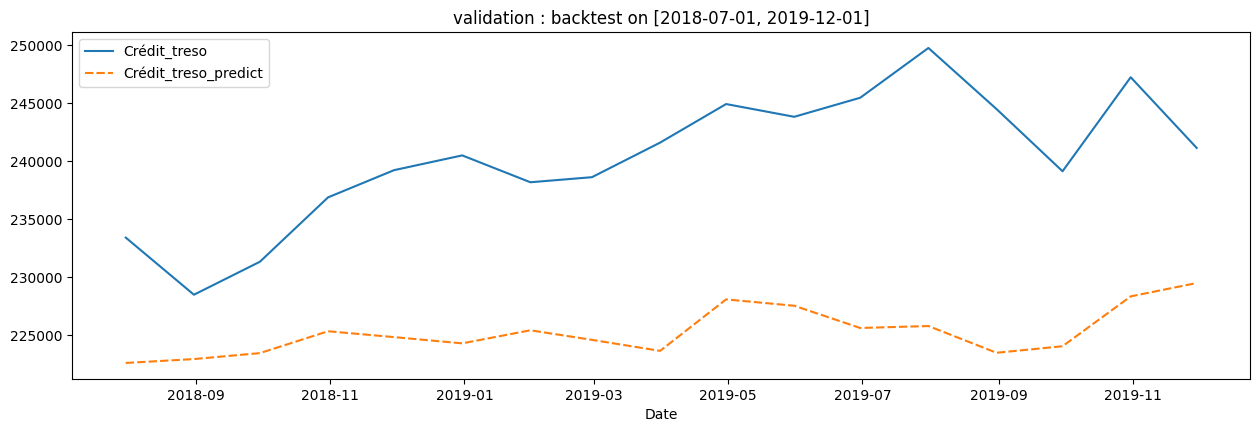

In [35]:
df_backtest['Crédit_treso_predict'] = lr.predict(df_backtest[drivers])

fig, ax = plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_backtest.set_index("Date")[["Crédit_treso", "Crédit_treso_predict"]], ax=ax)
figure.set_title(f"validation : backtest on [{backtest_range[0]}, {backtest_range[1]}]")
mape = sk.metrics.mean_absolute_percentage_error(df_backtest['Crédit_treso'], df_backtest['Crédit_treso_predict'])
print(f"fit : MAPE of {round(100*mape, 2)}%")
fig.show()